In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime 

import sqlite3
import sys
import time
import tqdm
import pickle
import joblib
import os

## Loading SQLite Database into Pandas DataFrames

The following code connects to an SQLite database (`melee_player_database.db`) and converts each table within the database into a pandas DataFrame. The DataFrames will be stored in a dictionary, where each key corresponds to the table name with `_df` appended, and the values are the respective DataFrames.

### Steps:

1. **Database Connection**: We use the `sqlite3` library to connect to the SQLite database file.
2. **Retrieve Table Names**: A query retrieves all the table names in the database.
3. **Convert Tables to DataFrames**: For each table:
   - The table is loaded into a pandas DataFrame using `pd.read_sql()`.
   - We check each column to see if any data is JSON-formatted (lists or dictionaries). If so, we convert these columns from strings into their corresponding Python objects using `json.loads()`.
4. **Store DataFrames**: The DataFrames are stored in a dictionary, where the key is the table name with a `_df` suffix, and the value is the DataFrame.
5. **Database Connection Closed**: Once all tables are loaded into DataFrames, the database connection is closed.

### Example:
If the database contains a table named `players`, the corresponding DataFrame will be stored in the dictionary with the key `players_df`, and can be accessed as:

```python
players_df = dfs['players_df']


In [52]:
# Function to get the table names
def get_table_names(conn):
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    return pd.read_sql(query, conn)['name'].tolist()

# Function to load tables into DataFrames
def load_tables_to_dfs(conn):
    table_names = get_table_names(conn)
    dataframes = {}
    
    for table in table_names:
        # Load table into a DataFrame
        df = pd.read_sql(f"SELECT * FROM {table}", conn)
        
        # Detect and convert JSON formatted columns (if any)
        for col in df.columns:
            # Check if any entry in the column is a valid JSON (list or dictionary)
            if df[col].apply(lambda x: isinstance(x, str)).all():
                try:
                    # Try parsing the column as JSON
                    df[col] = df[col].apply(lambda x: json.loads(x) if pd.notnull(x) else x)
                except (json.JSONDecodeError, TypeError):
                    # If it fails, skip the column
                    pass
        
        # Store the DataFrame with table name + '_df'
        dataframes[f"{table}_df"] = df
        
    return dataframes

if os.path.exists('../data/dfs_dict.pkl'):
    cell_has_run = True
    # Load the dictionary of DataFrames from the pickle
    with open('../data/dfs_dict.pkl', 'rb') as f:
        dfs = pickle.load(f)
# Check if the flag variable exists in the global scope so that this code does not run twice
if 'cell_has_run' not in globals():
    path = "../data/melee_player_database.db"
    
    # Connect to the database
    conn = sqlite3.connect(path)

    # Convert each table into a DataFrame
    dfs = load_tables_to_dfs(conn)

    # Close the connection
    conn.close()

    # Now, you have a dictionary 'dfs' where each key is the table name with '_df' suffix and value is the corresponding DataFrame.
    # For example, to access the DataFrame for a table called 'players':
    # players_df = dfs['players_df']

    dfs['tournament_info_df']['start'] = pd.to_datetime(dfs['tournament_info_df']['start'], unit='s')
    dfs['tournament_info_df']['end'] = pd.to_datetime(dfs['tournament_info_df']['end'], unit='s')

    
    # Set the flag to indicate that the cell has been run
    cell_has_run = True

### Here we adjust the data types of the dataframes so that they are the correct type. (This will be updated as needed.)

In [53]:
dfs['sets_df']['best_of'] = dfs['sets_df']['best_of'].fillna(0).astype(int) 

In [54]:
# # Save the dictionary of DataFrames as a pickle
# with open('../data/dfs_dict.pkl', 'wb') as f:
#     pickle.dump(dfs, f)

### Here we make dataframes that we will use and print the head.

The integers in 'characters' count the number of games the player has played that character. (We verify this for Zain below.)

In [55]:
players_df = dfs['players_df']
players_df.head()

,game,player_id,tag,all_tags,prefixes,social,country,state,region,c_country,c_state,c_region,placings,characters,alias
0,melee,Rishi,Rishi,[Rishi],[],{'twitter': []},,,,None,None,None,[{'key': 'mdva-invitational-2017-(challonge-mi...,,None
1,melee,15634,lloD,"[lloD, VGz | lloD, Llod]",[],{'twitter': ['lloD74']},United States,VA,,US,CA,Laurel,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/peach': 1089, 'melee/falco': 1, 'melee...",None
2,melee,6126,Zain,"[Zain, DontTestMe]",[PG],{'twitter': ['PG_Zain']},United States,VA,,US,CA,Los Angeles,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/marth': 1065, 'melee/pichu': 1, 'melee...",DontTestMe
3,melee,Chu,Chu,[Chu],[],{'twitter': []},,,,None,None,None,[{'key': 'mdva-invitational-2017-(challonge-mi...,,None
4,melee,5620,Junebug,"[Junebug, LS | VGz Junebug]",[],{'twitter': ['arJunebug']},United States,VA,,US,VA,Richmond,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/sheik': 46, 'melee/falco': 4, 'melee/g...",None


In [56]:
ranking_df = dfs['ranking_df']
ranking_df.head()

,game,ranking_name,priority,region,seasons,tournaments,icon
0,melee,SSBMRank,0,world,"[2015, 2016, 2017, 2018, 2019]",[],miom


In [57]:
ranking_seasons_df = dfs['ranking_seasons_df']
ranking_seasons_df.head()

,game,ranking_name,season,start,end,total,by_id,by_placing,final,name
0,melee,SSBMRank,2015,1420070400,1451606399,100,"{'6189': 1, '1004': 2, '4465': 3, '1000': 4, '...","{'1': '6189', '2': '1004', '3': '4465', '4': '...",0,None
1,melee,SSBMRank,2016,1451606400,1483228799,100,"{'6189': 1, '1004': 2, '1000': 3, '1003': 4, '...","{'1': '6189', '2': '1004', '3': '1000', '4': '...",0,None
2,melee,SSBMRank,2017,1483228800,1514764799,100,"{'1004': 1, '6189': 2, '1000': 3, '1003': 4, '...","{'1': '1004', '2': '6189', '3': '1000', '4': '...",0,None
3,melee,SSBMRank,2018,1514793600,1546329600,100,"{'1004': 1, '6189': 2, '4465': 3, '15990': 4, ...","{'1': '1004', '2': '6189', '3': '4465', '4': '...",0,None
4,melee,SSBMRank,2019,1546329600,1577836800,100,"{'1004': 1, '4465': 2, '1000': 3, '16342': 4, ...","{'1': '1004', '2': '4465', '3': '1000', '4': '...",0,None


In [58]:
sets_df = dfs['sets_df']
print(f"{sets_df[sets_df['game_data'].apply(lambda x: len(x) > 0)].shape[0] / sets_df.shape[0]:0.01%} percent of sets have some game data")
sets_df.head()


32.9% percent of sets have some game data


,key,game,tournament_key,winner_id,p1_id,p2_id,p1_score,p2_score,location_names,bracket_name,bracket_order,set_order,best_of,game_data
0,104675843,melee,mdva-invitational-2017-(challonge-mirror),5620,5620,Chillin,3,1,"[R1, Round 1, Round 1]",,1,A,5,[]
1,104675844,melee,mdva-invitational-2017-(challonge-mirror),Aglet,15634,Aglet,2,3,"[R1, Round 1, Round 1]",,1,B,5,[]
2,104675845,melee,mdva-invitational-2017-(challonge-mirror),6126,6126,1097,3,0,"[R1, Round 1, Round 1]",,1,C,5,[]
3,104675846,melee,mdva-invitational-2017-(challonge-mirror),1069,Chu,1069,0,3,"[R1, Round 1, Round 1]",,1,D,5,[]
4,104675847,melee,mdva-invitational-2017-(challonge-mirror),Rishi,Jerry,Rishi,1,3,"[R1, Round 1, Round 1]",,1,E,5,[]


In [59]:
tournament_info_df = dfs['tournament_info_df']
tournament_info_df.head()


,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,country,state,city,entrants,placings,losses,bracket_types,online,lat,lng
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,US,VA,Fall's Church,10,"[[Rishi, 1], [15634, 3], [6126, 4], [Chu, 8], ...",{},b'{}',0,NaN,NaN
1,melee,s@sh7,S@SH7,challonge,https://challonge.com/sash7,,17,,2017-06-13 10:27:01,2017-06-13 10:27:01,US,MI,Ann Arbor,92,[],{},b'{}',0,NaN,NaN
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,,,,20,"[[1000, 1], [6126, 2], [4107, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
3,melee,slippi-champions-league-week-2__melee-singles,Slippi Champions League Week 2,pgstats,slippi-champions-league-week-2,melee-singles,20,,2020-10-18 14:00:00,2020-10-18 14:00:00,,,,20,"[[6126, 1], [4107, 2], [1000, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
4,melee,slippi-champions-league-week-3__melee-singles,Slippi Champions League Week 3,pgstats,slippi-champions-league-week-3,melee-singles,20,,2020-10-25 14:00:00,2020-10-25 14:00:00,,,,20,"[[6126, 1], [3359, 2], [19554, 3], [4107, 3], ...",{},b'{}',1,0.0,0.0


## Games played by character ##
Count the games played by each character and plot.

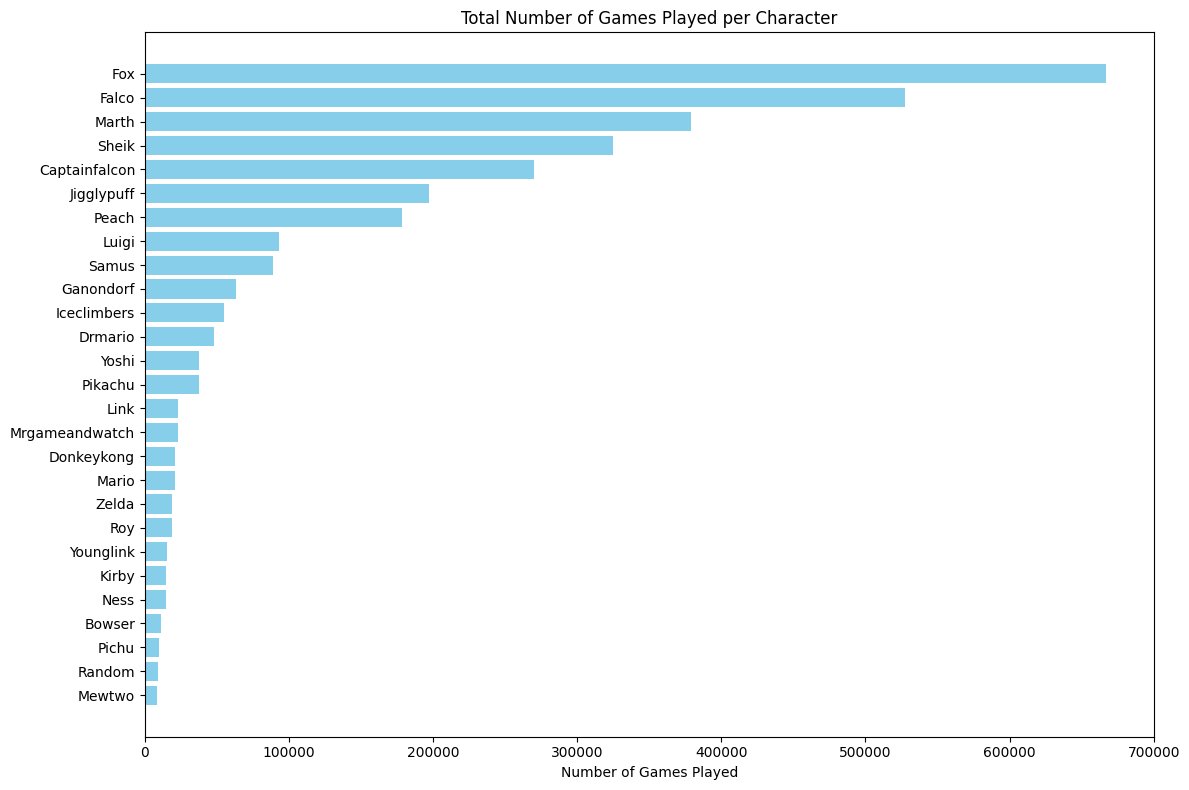

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume players_df is already loaded and contains the 'characters' column
# For this example, I'll use the provided players_df DataFrame

# Initialize an empty dictionary to store the total counts per character
total_character_counts = {}

# Iterate over the 'characters' column
for idx, row in players_df.iterrows():
    char_dict = row['characters']
    if isinstance(char_dict, dict):
        for character, count in char_dict.items():
            if character in total_character_counts:
                total_character_counts[character] += count
            else:
                total_character_counts[character] = count
    else:
        # Handle cases where 'characters' is empty or NaN
        continue

# Now total_character_counts contains the total counts per character

# Sort the characters by total counts in decreasing order
sorted_characters = sorted(total_character_counts.items(), key=lambda x: x[1], reverse=True)

# # Print the list of characters sorted by total number of games played
# print("Characters sorted by total number of games played:")
# for character, count in sorted_characters:
#     print(f"{character}: {count}")

# Prepare data for plotting
characters = [item[0].split('/')[1].title() for item in sorted_characters]
counts = [item[1] for item in sorted_characters]

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(characters, counts, color='skyblue')
plt.xlabel('Number of Games Played')
# plt.ylabel('Character')
plt.title('Total Number of Games Played per Character')
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.tight_layout()
plt.show()


## Investigate data for Zain
We choose zain because he is in the best player in the head of the players_df.

In [61]:
zain_df = players_df.iloc[2]
print('Zain has played in', len(zain_df['placings']), 'tournaments.')

# Dataframe of tournaments that zain has played in.
zain_tournament_keys = [tournament['key'] for tournament in zain_df['placings']]
zain_tournament_info_df = tournament_info_df[tournament_info_df['key'].isin(zain_tournament_keys)]

Zain has played in 180 tournaments.


In [62]:
print(zain_tournament_info_df.info())
zain_tournament_info_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0 to 39443
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   game              180 non-null    object        
 1   key               180 non-null    object        
 2   cleaned_name      180 non-null    object        
 3   source            180 non-null    object        
 4   tournament_name   180 non-null    object        
 5   tournament_event  180 non-null    object        
 6   season            180 non-null    object        
 7   rank              180 non-null    object        
 8   start             180 non-null    datetime64[ns]
 9   end               180 non-null    datetime64[ns]
 10  country           126 non-null    object        
 11  state             124 non-null    object        
 12  city              114 non-null    object        
 13  entrants          180 non-null    int64         
 14  placings          180 non-nul

,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,country,state,city,entrants,placings,losses,bracket_types,online,lat,lng
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,US,VA,Fall's Church,10,"[[Rishi, 1], [15634, 3], [6126, 4], [Chu, 8], ...",{},b'{}',0,NaN,NaN
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,,,,20,"[[1000, 1], [6126, 2], [4107, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
3,melee,slippi-champions-league-week-2__melee-singles,Slippi Champions League Week 2,pgstats,slippi-champions-league-week-2,melee-singles,20,,2020-10-18 14:00:00,2020-10-18 14:00:00,,,,20,"[[6126, 1], [4107, 2], [1000, 3], [19554, 3], ...",{},b'{}',1,0.0,0.0
4,melee,slippi-champions-league-week-3__melee-singles,Slippi Champions League Week 3,pgstats,slippi-champions-league-week-3,melee-singles,20,,2020-10-25 14:00:00,2020-10-25 14:00:00,,,,20,"[[6126, 1], [3359, 2], [19554, 3], [4107, 3], ...",{},b'{}',1,0.0,0.0
5,melee,slippi-champions-league-week-4__melee-singles,Slippi Champions League Week 4,pgstats,slippi-champions-league-week-4,melee-singles,20,,2020-10-31 14:00:00,2020-10-31 14:00:00,,,,20,"[[6126, 1], [3357, 2], [15990, 3], [3359, 3], ...",{},b'{}',1,0.0,0.0


Here we make a dataframe containing all the sets that zain has played in and add some columns so that we can identify him more easily.

In [63]:
# Filter sets_df with Zain as a player and make a copy
zain_sets_df = sets_df[(sets_df['p1_id'] == zain_df['player_id']) | (sets_df['p2_id'] == zain_df['player_id'])].copy()
print('Zain has played', zain_sets_df.shape[0], 'sets.')

# Assuming zain_df['player_id'] gives Zain's player ID
zain_id = zain_df['player_id']

# Add a 'zain_win' column using .loc
zain_sets_df.loc[:, 'zain_win'] = ((zain_sets_df['p1_id'] == zain_id) & (zain_sets_df['p1_score'] > zain_sets_df['p2_score'])) | \
                                  ((zain_sets_df['p2_id'] == zain_id) & (zain_sets_df['p2_score'] > zain_sets_df['p1_score']))

# Add an 'opponent' column using .loc
zain_sets_df.loc[:, 'opponent'] = zain_sets_df.apply(
    lambda row: row['p1_id'] if row['p2_id'] == zain_id else row['p2_id'],
    axis=1
)

# Add 'zain_score' and 'opponent_score' columns using .loc
zain_sets_df.loc[:, 'zain_score'] = zain_sets_df.apply(
    lambda row: row['p1_score'] if row['p1_id'] == zain_id else row['p2_score'],
    axis=1
)

zain_sets_df.loc[:, 'opponent_score'] = zain_sets_df.apply(
    lambda row: row['p2_score'] if row['p1_id'] == zain_id else row['p1_score'],
    axis=1
)

# Filter the zain_sets_df for rows where 'game_data' is not an empty list
game_data_zain_sets_df = zain_sets_df[zain_sets_df['game_data'].apply(lambda x: len(x) > 0)]

# Display the result
print('Zain has played', game_data_zain_sets_df.shape[0], 'sets with game_data.')


Zain has played 1344 sets.
Zain has played 575 sets with game_data.


Here we check to see that zain_df['characters'] counts the number of games that zain has played that character.

In [64]:
# Ensure zain_id is a string to match the data in game_data
zain_id = str(zain_id)

# Initialize a dictionary to count Zain's characters
zain_characters_count = defaultdict(int)

# Loop through the 'game_data' for each set Zain played
for game_data in game_data_zain_sets_df['game_data']:
    for game in game_data:
        # Check if Zain was the winner or loser and increment the count of the character he used
        if str(game['winner_id']) == zain_id:  # Compare as strings
            zain_characters_count[game['winner_char']] += 1
        elif str(game['loser_id']) == zain_id:  # Compare as strings
            zain_characters_count[game['loser_char']] += 1

# Convert the defaultdict to a regular dict and display the result
zain_characters_count = dict(zain_characters_count)
# print(zain_characters_count)
# print(zain_df['characters'])

# Extract the characters dictionary from zain_df
zain_characters_actual = zain_df['characters']

# Find the keys that are common to both dictionaries
common_keys = set(zain_characters_count.keys()).intersection(set(zain_characters_actual.keys()))

# Compare the values for the keys that are common
for key in common_keys:
    if zain_characters_count[key] == zain_characters_actual[key]:
        print(f"{key}: Match - {zain_characters_count[key]} games")
    else:
        print(f"{key}: Mismatch - counted {zain_characters_count[key]} games, actual {zain_characters_actual[key]} games")

melee/drmario: Match - 1 games
melee/roy: Match - 696 games
melee/luigi: Match - 2 games
melee/falco: Match - 10 games
melee/sheik: Match - 37 games
melee/captainfalcon: Match - 3 games
melee/peach: Match - 1 games
melee/pichu: Match - 1 games
melee/iceclimbers: Match - 2 games
melee/jigglypuff: Match - 12 games
melee/fox: Match - 125 games
melee/marth: Match - 1065 games
melee/mewtwo: Match - 1 games
melee/zelda: Match - 1 games
melee/link: Match - 1 games
melee/random: Match - 2 games
melee/samus: Match - 1 games


## Overall Glicko-2 Exploration ##


Here we see what happens if we only have one update to a player's glicko rating.  It can blow up. We simulate what happens when a player's first update contains 3 wins against players with glicko-2 rating i and  rd value of 100.

In [65]:
from glicko2 import Player
player = Player()
for i in range(0,3200, 200):
    player = Player()
    # player._tau = 1.2
    # print(player._tau)
    player.update_player([i, i, i],[100, 100, 100],[1, 1, 1])
    print(f'{i} : {int(player.getRating())}')

0 : 1500
200 : 1501
400 : 1504
600 : 1513
800 : 1534
1000 : 1574
1200 : 1630
1400 : 1707
1600 : 1858
1800 : 2176
2000 : 2663
2200 : 3109
2400 : 3358
2600 : 3461
2800 : 3498
3000 : 3511


## Highest Glicko every 6 months ##
Here we investigate who has the highest Glicko-2 rating every 6 months of the dataset.

In [66]:
glicko2_df = pd.read_pickle('../data/overall_players_ranking_2.pkl')

If we just look for the highest rating of the dataset, we get some nonsense (players we don't expect to see appear in the list).

In [67]:
def get_index_of_date(dates, target_date):
    return np.searchsorted(dates, target_date) - 1

# filtered_glicko = glicko2_df.copy()


for year in range(2016, 2025):
    for month in [1, 6]:
        filtered_glicko = glicko2_df.copy()
        
        target_date = datetime.datetime(year, month, 1)

        indices = filtered_glicko['dates'].apply(lambda x: get_index_of_date(x, target_date))
        
        # Filter out the players that have not entered a tournament yet.
        filtered_glicko = filtered_glicko[indices > 0]
        
        # Extract ratings as a Series, ensuring correct data type
        ratings_on_date = filtered_glicko.apply(
            lambda row: row['rating_history'][indices[row.name]], axis=1
        )

        rd_on_date = filtered_glicko.apply(
            lambda row: row['rd_history'][indices[row.name]], axis=1
        )

        # Ensure ratings_on_date is a Series and sort it
        top_5 = ratings_on_date.sort_values(ascending=False)[:10]

        # Retrieve the player tags along with their ratings
        top_5_df = players_df[players_df['player_id'].isin(top_5.index)]
        top_5_df = top_5_df.set_index('player_id').loc[top_5.index]
        top_5_df['rating'] = top_5.values.astype(int)

        # Display the top 5 players sorted by rating
        print(f"Date: {target_date.strftime('%Y-%m-%d')}")
        print(top_5_df[['tag', 'rating']].to_string(index=False))
        print()


Date: 2016-01-01
      tag  rating
   Armada    2150
Hungrybox    2077
    Abate    2073
    Mang0    1994
     PPMD    1988
   Leffen    1973
 Mew2King    1969
     Plup    1958
 Shroomed    1926
   Slayer    1920

Date: 2016-06-01
      tag  rating
   Armada    2151
Hungrybox    2133
  Arkouda    2098
    Mang0    2097
   Leffen    2027
    Updog    2002
 Mew2King    1982
     Plup    1982
     Beat    1967
    Abate    1962

Date: 2017-01-01
      tag  rating
   Armada    2248
Hungrybox    2183
    Mang0    2132
 Mew2King    2072
     Twin    2063
   Leffen    2059
   Cyrain    2029
      Ice    2021
     Plup    2011
  Arkouda    2009

Date: 2017-06-01
            tag  rating
         Armada    2275
      Hungrybox    2237
          Mang0    2152
       Mew2King    2135
         Leffen    2094
           SFAT    2076
           Plup    2075
           Sami    2073
           Twin    2063
Swedish Delight    2062

Date: 2018-01-01
      tag  rating
Hungrybox    2336
   Armada    2314

Knowing that players with only one update to their rank can be very high (see above), we filter out players that have gone to fewer than 5 tournaments.

In [68]:
def get_index_of_date(dates, target_date):
    return np.searchsorted(dates, target_date) - 1


for year in range(2016, 2025):
    for month in [1, 6]:
        # First filter out the players who have only a few updates (played in 5 tournaments)
        filtered_glicko = glicko2_df[glicko2_df['dates'].apply(len) > 4]
        
        target_date = datetime.datetime(year, month, 1)

        indices = filtered_glicko['dates'].apply(lambda x: get_index_of_date(x, target_date))
        
        # Filter out the players that have not entered a tournament yet.
        filtered_glicko = filtered_glicko[indices > 0]

        # Extract ratings as a Series, ensuring correct data type
        # print(indices)
        ratings_on_date = filtered_glicko.apply(
            lambda row: row['rating_history'][indices[row.name]], axis=1
        )

        rd_on_date = filtered_glicko.apply(
            lambda row: row['rd_history'][indices[row.name]], axis=1
        )

        # Ensure ratings_on_date is a Series and sort it
        top_5 = ratings_on_date.sort_values(ascending=False)[:10]

        # Retrieve the player tags along with their ratings
        top_5_df = players_df[players_df['player_id'].isin(top_5.index)]
        top_5_df = top_5_df.set_index('player_id').loc[top_5.index]
        top_5_df['rating'] = top_5.values.astype(int)

        # Display the top 5 players sorted by rating
        print(f"Date: {target_date.strftime('%Y-%m-%d')}")
        print(top_5_df[['tag', 'rating']].to_string(index=False))
        print()

Date: 2016-01-01
      tag  rating
   Armada    2150
Hungrybox    2077
    Abate    2073
    Mang0    1994
     PPMD    1988
   Leffen    1973
 Mew2King    1969
     Plup    1958
 Shroomed    1926
   Slayer    1920

Date: 2016-06-01
      tag  rating
   Armada    2151
Hungrybox    2133
  Arkouda    2098
    Mang0    2097
   Leffen    2027
    Updog    2002
 Mew2King    1982
     Plup    1982
    Abate    1962
Westballz    1943

Date: 2017-01-01
            tag  rating
         Armada    2248
      Hungrybox    2183
          Mang0    2132
       Mew2King    2072
         Leffen    2059
            Ice    2021
           Plup    2011
        Arkouda    2009
      Westballz    2007
Swedish Delight    2002

Date: 2017-06-01
            tag  rating
         Armada    2275
      Hungrybox    2237
          Mang0    2152
       Mew2King    2135
         Leffen    2094
           SFAT    2076
           Plup    2075
           Sami    2073
Swedish Delight    2062
    Hanky Panky    2036

Date

## Baseline Glicko-2 Prediction ##
We see how often the player with the higher Glicko-2 rating wins. The baseline of 72.3% does not initially seem too bad.

In [69]:
random_set_sample = sets_df#.sample(n=num_sets, random_state=42)

# Merge with 'tournament_info_df' to get 'start' date
random_set_sample = random_set_sample.merge(
    tournament_info_df[['key', 'start']],
    left_on='tournament_key',
    right_on='key',
    how='left'
)

# Ensure date columns are datetime
random_set_sample['start'] = pd.to_datetime(random_set_sample['start'])

# Flatten 'glicko2_df'
glicko2_long = glicko2_df[['dates', 'rating_history']].reset_index()

glicko2_long = glicko2_long.explode(['dates', 'rating_history'])
glicko2_long.rename(columns={'dates': 'date', 'rating_history': 'rating'}, inplace=True)
glicko2_long['date'] = pd.to_datetime(glicko2_long['date'])

# For Player 1
p1_data = random_set_sample[['p1_id', 'start']].rename(columns={'p1_id': 'player_id'})
p1_data['key'] = p1_data.index

p1_ratings = pd.merge_asof(
    p1_data.sort_values('start'),
    glicko2_long.sort_values('date'),
    by='player_id',
    left_on='start',
    right_on='date',
    direction='backward'
).set_index('key')

# For Player 2
p2_data = random_set_sample[['p2_id', 'start']].rename(columns={'p2_id': 'player_id'})
p2_data['key'] = p2_data.index

p2_ratings = pd.merge_asof(
    p2_data.sort_values('start'),
    glicko2_long.sort_values('date'),
    by='player_id',
    left_on='start',
    right_on='date',
    direction='backward'
).set_index('key')

# Combine ratings
combined_ratings = pd.DataFrame({
    'p1_rating': p1_ratings['rating'],
    'p2_rating': p2_ratings['rating'],
    'winner_id': random_set_sample['winner_id'],
    'p1_id': random_set_sample['p1_id'],
    'p2_id': random_set_sample['p2_id']
})

# Drop missing ratings
combined_ratings.dropna(subset=['p1_rating', 'p2_rating'], inplace=True)

# Update number of sets
num_sets = combined_ratings.shape[0]

# Determine if the higher-rated player won
higher_p1_wins = (
    (combined_ratings['p1_rating'] > combined_ratings['p2_rating']) &
    (combined_ratings['winner_id'] == combined_ratings['p1_id'])
)
higher_p2_wins = (
    (combined_ratings['p2_rating'] > combined_ratings['p1_rating']) &
    (combined_ratings['winner_id'] == combined_ratings['p2_id'])
)
correct_predictions = (higher_p1_wins | higher_p2_wins).sum()

print(f'The higher Glicko-2 rating wins {correct_predictions / num_sets:0.1%} of the time')
print(f'There were {correct_predictions} correct predictions out of {num_sets} sets.')

The higher Glicko-2 rating wins 72.3% of the time
There were 1298224 correct predictions out of 1795667 sets.


I don't think that a single number tells the whole story. We make a bar chart that shows the accuracy of the prediction for different skill gaps in rating. We see that the pridictive accuracy of the Glicko-2 rating is barely better than a guess when the difference in rating is less than 100.

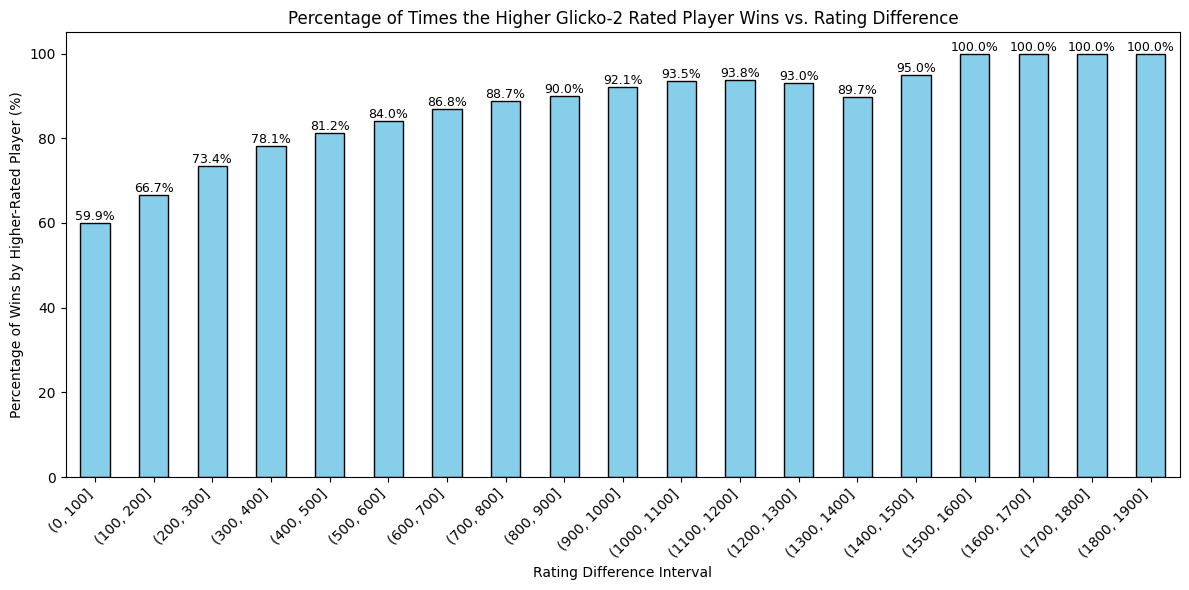

In [70]:
# Compute rating difference
combined_ratings['rating_diff'] = abs(combined_ratings['p1_rating'] - combined_ratings['p2_rating'])

# Determine if the higher-rated player won
combined_ratings['higher_rated_won'] = (
    ((combined_ratings['rating_diff'] > 0) & (combined_ratings['winner_id'] == combined_ratings['p1_id'])) |
    ((combined_ratings['rating_diff'] < 0) & (combined_ratings['winner_id'] == combined_ratings['p2_id']))
)

# Bin the rating differences with bin sizes of 100
bin_size = 100
min_rating_diff = combined_ratings['rating_diff'].min()
max_rating_diff = combined_ratings['rating_diff'].max()
bins = np.arange(
    np.floor(min_rating_diff / bin_size) * bin_size,
    np.ceil(max_rating_diff / bin_size) * bin_size + bin_size,
    bin_size, dtype=int
)

# Assign bins without specifying labels (default labels are intervals)
combined_ratings['rating_diff_bin'] = pd.cut(combined_ratings['rating_diff'], bins)

# Group by bins and compute the percentage of higher-rated player wins
result = combined_ratings.groupby('rating_diff_bin', observed=False)['higher_rated_won'].agg(['mean', 'count'])
result['mean'] = result['mean'] * 100  # Convert to percentage

# Reset index to turn 'rating_diff_bin' into a column
result = result.reset_index()

# Convert interval labels to strings for x-axis labels
result['rating_diff_bin_str'] = result['rating_diff_bin'].astype(str)

# Plot the histogram
plt.figure(figsize=(12, 6))
ax = result['mean'].plot(kind='bar', color='skyblue', edgecolor='black')

# Set x-axis labels to be the interval strings
ax.set_xticklabels(result['rating_diff_bin_str'])

plt.title('Percentage of Times the Higher Glicko-2 Rated Player Wins vs. Rating Difference')
plt.xlabel('Rating Difference Interval')
plt.ylabel('Percentage of Wins by Higher-Rated Player (%)')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of each bar
for p, value in zip(ax.patches, result['mean']):
    height = p.get_height()
    ax.annotate(f'{value:.1f}%', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

To check to see how much of a problem this is, we see how many games are played between players of different rating gaps. As we see, most games are played by players whose rating are close. This will likely be a problem for us.

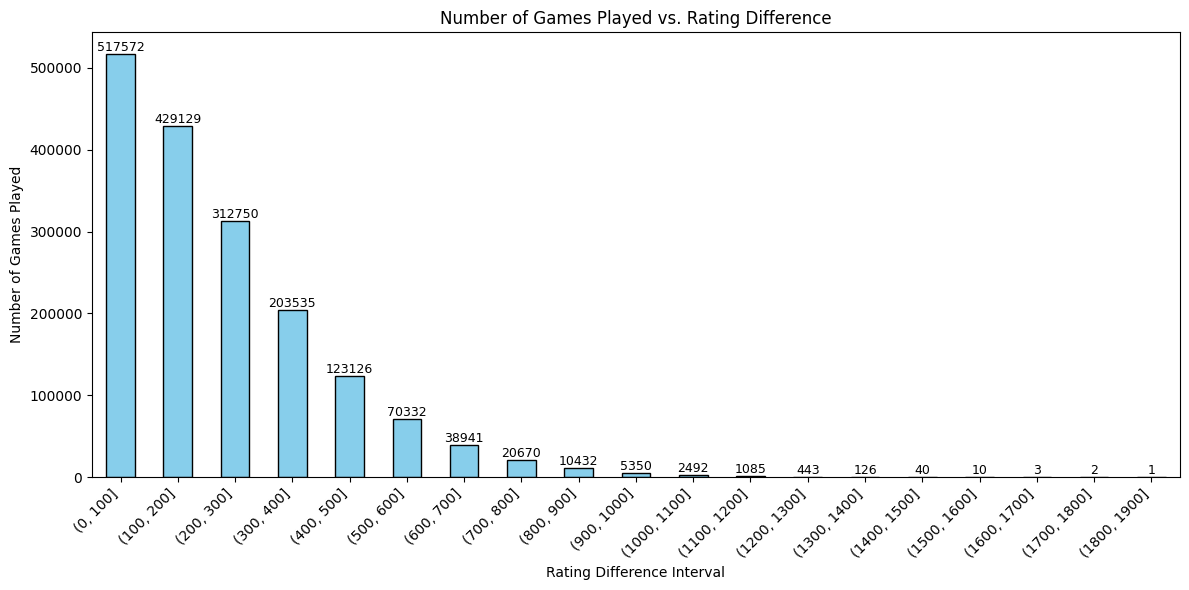

In [71]:
# Compute rating difference
combined_ratings['rating_diff'] = abs(combined_ratings['p1_rating'] - combined_ratings['p2_rating'])

# Bin the rating differences with bin sizes of 100
bin_size = 100
min_rating_diff = combined_ratings['rating_diff'].min()
max_rating_diff = combined_ratings['rating_diff'].max()
bins = np.arange(
    np.floor(min_rating_diff / bin_size) * bin_size,
    np.ceil(max_rating_diff / bin_size) * bin_size + bin_size,
    bin_size, dtype=int
)

# Assign bins without specifying labels (default labels are intervals)
combined_ratings['rating_diff_bin'] = pd.cut(combined_ratings['rating_diff'], bins)

# Group by bins and compute the count of games played
result = combined_ratings.groupby('rating_diff_bin', observed=False).size().reset_index(name='count')

# Convert interval labels to strings for x-axis labels
result['rating_diff_bin_str'] = result['rating_diff_bin'].astype(str)

# Plot the histogram
plt.figure(figsize=(12, 6))
ax = result['count'].plot(kind='bar', color='skyblue', edgecolor='black')

# Set x-axis labels to be the interval strings
ax.set_xticklabels(result['rating_diff_bin_str'])

plt.title('Number of Games Played vs. Rating Difference')
plt.xlabel('Rating Difference Interval')
plt.ylabel('Number of Games Played')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for p, value in zip(ax.patches, result['count']):
    height = p.get_height()
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


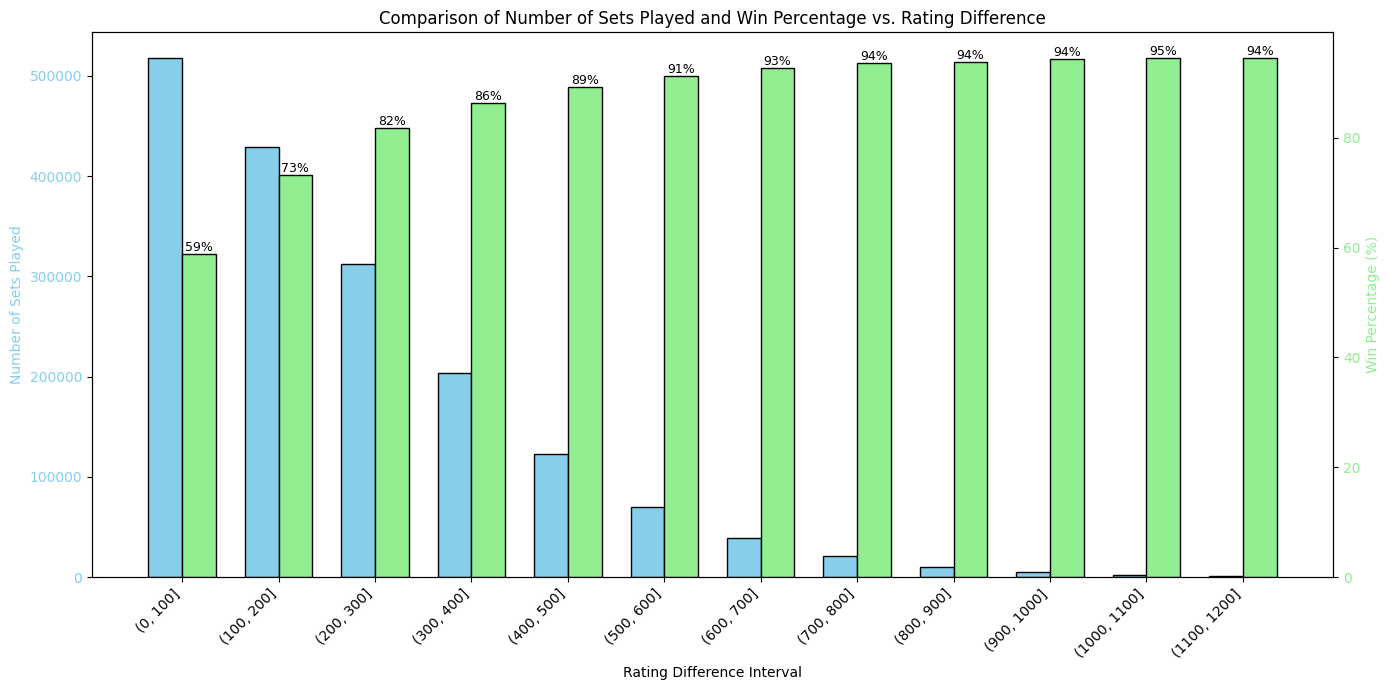

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute rating difference
combined_ratings['rating_diff'] = abs(combined_ratings['p1_rating'] - combined_ratings['p2_rating'])

# Bin the rating differences with bin sizes of 100
bin_size = 100
min_rating_diff = combined_ratings['rating_diff'].min()
max_rating_diff = min(1200, combined_ratings['rating_diff'].max())  # Limit to 1200

bins = np.arange(
    np.floor(min_rating_diff / bin_size) * bin_size,
    np.ceil(max_rating_diff / bin_size) * bin_size + bin_size,
    bin_size, dtype=int
)

# Assign bins without labels
combined_ratings['rating_diff_bin'] = pd.cut(combined_ratings['rating_diff'], bins)

# Filter out intervals beyond 1200
filtered_data = combined_ratings[combined_ratings['rating_diff'] <= 1200]

# Determine if the higher-rated player won, using .loc to avoid SettingWithCopyWarning
filtered_data = filtered_data.copy()
filtered_data.loc[:, 'higher_rated_won'] = (
    ((filtered_data['p1_rating'] > filtered_data['p2_rating']) & (filtered_data['winner_id'] == filtered_data['p1_id'])) |
    ((filtered_data['p1_rating'] < filtered_data['p2_rating']) & (filtered_data['winner_id'] == filtered_data['p2_id']))
)

# Group by bins and compute count and win stats
game_counts = filtered_data.groupby('rating_diff_bin', observed=False).size().reset_index(name='count')
win_stats = filtered_data.groupby('rating_diff_bin', observed=False)['higher_rated_won'].agg(['mean', 'count'])
win_stats['mean'] = win_stats['mean'] * 100  # Convert to percentage

# Merge both dataframes
result = pd.merge(game_counts, win_stats, on='rating_diff_bin')

# Convert interval labels to strings for x-axis
result['rating_diff_bin_str'] = result['rating_diff_bin'].astype(str)

# Plot the data
fig, ax1 = plt.subplots(figsize=(14, 7))

# X-axis positions for bars
bar_width = 0.35  # Width of each bar
x = np.arange(len(result))

# Plot the number of games
bars1 = ax1.bar(x - bar_width / 2, result['count_x'], bar_width, 
                label='Number of Games', color='skyblue', edgecolor='black')
ax1.set_xlabel('Rating Difference Interval')
ax1.set_ylabel('Number of Sets Played', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Create a twin y-axis for the win percentage
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width / 2, result['mean'], bar_width, 
                label='Win Percentage (Higher Rated)', color='lightgreen', edgecolor='black')
ax2.set_ylabel('Win Percentage (%)', color='lightgreen')
ax2.tick_params(axis='y', labelcolor='lightgreen')

# Set x-axis labels and ticks
ax1.set_xticks(x)
ax1.set_xticklabels(result['rating_diff_bin_str'], rotation=45, ha='right')

# Add labels for win percentage bars
for bar, value in zip(bars2, result['mean']):
    height = bar.get_height()
    ax2.annotate(f'{round(value)}%', 
                 (bar.get_x() + bar.get_width() / 2, height), 
                 ha='center', va='bottom', fontsize=9)

# Add a title and ensure layout is tight
plt.title('Comparison of Number of Sets Played and Win Percentage vs. Rating Difference')
fig.tight_layout()

plt.show()


## Matchup specfic Glicko-2 ##

In [73]:
matchup_glicko = pd.read_pickle('../data/player_ratings_matchup_df_2.pkl')
matchup_glicko.head()

,player_id,dates_dict,rating_history_dict,rd_history_dict,game_count_dict,glicko2_dict
0,4643,{'melee/jigglypuff': {'melee/falco': [2015-04-...,{'melee/jigglypuff': {'melee/falco': [1799.625...,{'melee/jigglypuff': {'melee/falco': [227.7354...,"{'melee/jigglypuff': {'melee/falco': 3, 'melee...",{'melee/jigglypuff': {'melee/zelda': <glicko2....
1,4005,{'melee/mario': {'melee/falco': [2015-04-13 05...,{'melee/mario': {'melee/falco': [1799.62583569...,{'melee/mario': {'melee/falco': [227.735414619...,"{'melee/mario': {'melee/falco': 3, 'melee/jigg...",{'melee/mario': {'melee/marth': <glicko2.glick...
2,4624,{'melee/jigglypuff': {'melee/pikachu': [2015-0...,{'melee/jigglypuff': {'melee/pikachu': [1747.3...,{'melee/jigglypuff': {'melee/pikachu': [253.40...,"{'melee/jigglypuff': {'melee/pikachu': 2}, 'me...",{'melee/zelda': {'melee/pikachu': <glicko2.gli...
3,4469,{'melee/falco': {'melee/marth': [2015-04-13 05...,{'melee/falco': {'melee/marth': [1747.31808324...,{'melee/falco': {'melee/marth': [253.404608225...,"{'melee/falco': {'melee/marth': 2, 'melee/pika...",{'melee/marth': {'melee/jigglypuff': <glicko2....
4,6189,{'melee/falco': {'melee/fox': [2015-04-13 05:0...,{'melee/falco': {'melee/fox': [1662.3108949761...,{'melee/falco': {'melee/fox': [290.31896467475...,"{'melee/falco': {'melee/fox': 2, 'melee/peach'...",{'melee/fox': {'melee/zelda': <glicko2.glicko2...


## aMSa v Cody rating ##
Here we plot aMSa's vs Fox and Cody's vs Yoshi. Cody pretty much always beats aMSa and I would expect that his Fox vs Yoshi matchup rating to be higher than aMSa's Yoshi vs Fox rating. We need to understand why the ratings do not reflect the results.

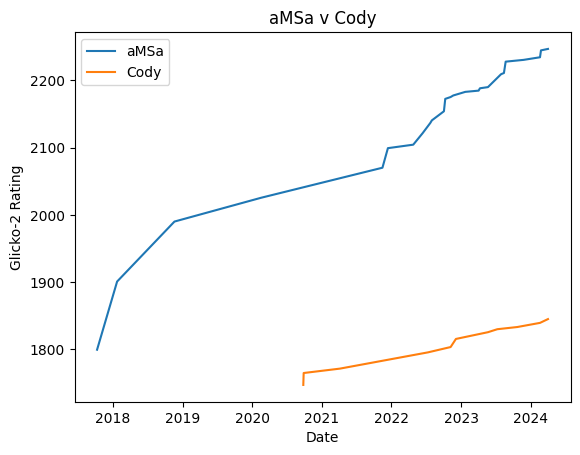

In [74]:
# Extract the relevant row from the DataFrame
player_data = matchup_glicko.loc[matchup_glicko['player_id'] == '1021', 'rating_history_dict'].values[0]
date_value = matchup_glicko.loc[matchup_glicko['player_id'] == '1021', 'dates_dict'].values[0]
# Access the specific nested data: melee/yoshi vs melee/fox
yoshi_vs_fox_ratings = player_data['melee/yoshi']['melee/fox']

plt.figure()
plt.plot(date_value['melee/yoshi']['melee/fox'], player_data['melee/yoshi']['melee/fox'], label='aMSa')

# Extract the relevant row from the DataFrame
player_data = matchup_glicko.loc[matchup_glicko['player_id'] == '19554', 'rating_history_dict'].values[0]
date_value = matchup_glicko.loc[matchup_glicko['player_id'] == '19554', 'dates_dict'].values[0]
# Access the specific nested data: melee/yoshi vs melee/fox
fox_vs_yoshi_ratings = player_data['melee/fox']['melee/yoshi']
plt.title('aMSa v Cody')
plt.xlabel('Date')
plt.ylabel('Glicko-2 Rating')

plt.plot(date_value['melee/fox']['melee/yoshi'], player_data['melee/fox']['melee/yoshi'], label='Cody')
plt.legend()
plt.show()

In [135]:
# Define the player and opponent characters
player_character = 'melee/fox'
opponent_character = 'melee/falco'



def get_matchup(matchup_glicko, player_character, opponent_character):
    # Safely access nested dictionaries with error handling
    def extract_dates(nested_dict):
        """Safely extract the dates for a given player and opponent matchup."""
        try:
            # Extract the dates if both keys are present
            return nested_dict.get(player_character, {}).get(opponent_character, [])
        except AttributeError:
            # Handle cases where the structure is not as expected
            return []  # Default fallback
        
    # Copy the original DataFrame
    glicko2_matchup = matchup_glicko.copy()
    
    # Apply the extraction function
    glicko2_matchup['dates'] = glicko2_matchup['dates_dict'].apply(extract_dates)
    glicko2_matchup['rating_history'] = glicko2_matchup['rating_history_dict'].apply(extract_dates)
    glicko2_matchup['rd_history'] = glicko2_matchup['rating_history_dict'].apply(extract_dates)
    # glicko2_matchup['extracted_dates'] = glicko2_matchup['dates_dict'].apply(extract_dates)

    # glicko2_matchup.

    # Check the first few rows to verify the result
    # print(glicko2_matchup[['player_id','dates_dict', 'extracted_dates','extracted_rating']].head())
    glicko2_matchup_filtered = glicko2_matchup[glicko2_matchup['dates'].apply(len) > 0][['player_id','dates', 'rating_history','rd_history']]
    glicko2_matchup_filtered.set_index(glicko2_matchup_filtered['player_id'], inplace=True)

    return glicko2_matchup_filtered[['dates', 'rating_history','rd_history']]

def get_index_of_date(dates, target_date):
    return np.searchsorted(dates, target_date) - 1


print(get_matchup(matchup_glicko,'melee/fox', 'melee/falco'))
# print(glicko2_df)

def print_top_players(glicko2_df, n_players = 5):
    for year in range(2016, 2025):
        for month in [1, 6]:
            # First filter out the players who have only a few updates (played in 5 tournaments)
            filtered_glicko = glicko2_df[glicko2_df['dates'].apply(len) > 4]
            
            target_date = datetime.datetime(year, month, 1)

            indices = filtered_glicko['dates'].apply(lambda x: get_index_of_date(x, target_date))
            
            # Filter out the players that have not entered a tournament yet.
            filtered_glicko = filtered_glicko[indices > 0]

            # Extract ratings as a Series, ensuring correct data type
            # print(indices)
            ratings_on_date = filtered_glicko.apply(
                lambda row: row['rating_history'][indices[row.name]], axis=1
            )

            rd_on_date = filtered_glicko.apply(
                lambda row: row['rd_history'][indices[row.name]], axis=1
            )

            # Ensure ratings_on_date is a Series and sort it
            top_5 = ratings_on_date.sort_values(ascending=False)[:n_players]

            # Retrieve the player tags along with their ratings
            top_5_df = players_df[players_df['player_id'].isin(top_5.index)]
            top_5_df = top_5_df.set_index('player_id').loc[top_5.index]

            top_5_df['rating'] = top_5.values.astype(int)

            # Display the top 5 players sorted by rating
            print(f"Date: {target_date.strftime('%Y-%m-%d')}")
            print(top_5_df[['tag', 'rating']].to_string(index=False))
            print()


# Example usage: print top players for Fox vs Falco
print_top_players(get_matchup(matchup_glicko, 'melee/fox', 'melee/falco'), 10)

# get_matchup(matchup_glicko,'melee/fox', 'melee/falco')

print_top_players(get_matchup(matchup_glicko,'melee/fox', 'melee/falco'), 10)


                                                       dates  \
player_id                                                      
6189       [2015-04-13 05:00:00, 2015-11-08 08:00:00, 201...   
4532                                   [2023-12-01 04:55:00]   
4421                                   [2015-04-13 05:00:00]   
1000       [2015-04-13 05:00:00, 2015-10-05 03:00:00, 201...   
4409                                   [2015-04-13 05:00:00]   
...                                                      ...   
4136807                                [2024-06-22 05:00:00]   
4140889                                [2024-06-22 05:00:00]   
4066405                                [2024-06-22 11:00:00]   
2791218                                [2024-06-23 20:00:00]   
911272                                 [2024-12-31 15:59:00]   

                                              rating_history  \
player_id                                                      
6189       [1799.6258356900184, 1841.70

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

This code will visualize the effect of different values of tau in the calculation.

In [75]:
# matchup_glicko_3 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_3_df.pkl')
# matchup_glicko_5 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_5_df.pkl')
# matchup_glicko_7 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_7_df.pkl')
# matchup_glicko_9 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_9_df.pkl')
# matchup_glicko_11 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_11_df.pkl')
# matchup_glicko_13 = pd.read_pickle('../player_ratings_matchup_data/player_ratings_matchup_tau_13_df.pkl')


In [76]:
# # Extract the relevant row from the DataFrame
# glicko_data_list = [matchup_glicko_3, matchup_glicko_5, matchup_glicko_7, matchup_glicko_9, matchup_glicko_11, matchup_glicko_13]
# # glicko_data_list = [matchup_glicko_3, matchup_glicko_5]
# titles  = ['tau = .3', 'tau = .5', 'tau = .7', 'tau = .9', 'tau = 1.1', 'tau = 1.3']

# # Create subplots
# fig, ax = plt.subplots(3, 2, figsize=(16, 18))

# # Add a main title to the figure
# fig.suptitle('aMSa and Cody matchup rating by tau', fontsize=16)


# for i, data in enumerate(glicko_data_list):
#     amsa_matchup = data.loc[data['player_id'] == '1021']
#     cody_matchup = data.loc[data['player_id'] == '19554']
    
#     amsa_dates = amsa_matchup['dates_dict'].values[0]['melee/yoshi']['melee/fox']
#     cody_dates = cody_matchup['dates_dict'].values[0]['melee/fox']['melee/yoshi']
    
#     amsa_ratings = amsa_matchup['rating_history_dict'].values[0]['melee/yoshi']['melee/fox']
#     cody_ratings = cody_matchup['rating_history_dict'].values[0]['melee/fox']['melee/yoshi']
    
#     # Determine the subplot position in the 3x2 grid
#     row, col = divmod(i, 2)
    
#     ax[row, col].plot(amsa_dates, amsa_ratings, label='aMSa')
#     ax[row, col].plot(cody_dates, cody_ratings, label='Cody')
#     ax[row, col].legend()
#     ax[row, col].set_title(titles[i])


